In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns

from collections import defaultdict
from itertools import combinations, permutations
from matplotlib import rcParams
from os import listdir
from os.path import join
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway, ttest_ind, fisher_exact, hypergeom
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'

plot_dir = 'figures'
data_dir = 'data'

In [2]:
# Load AGORA taxa
df = pd.read_csv(data_dir + '/agora_taxa.tsv', delimiter='\t')
df['species'] = [x[1] for x in df.organism.str.split(' ')]
agora_tax_df = df
agora_tax_df

,organism,seedid,kingdom,phylum,mclass,order,family,genus,oxygenstat,metabolism,...,reactions,metabolites,draftcreator,draftcreated,phenotype,imgid,ncbiid,platform,kbaseid,species
0,Abiotrophia defectiva ATCC 49176,Abiotrophia defectiva ATCC 49176 (592010.4),Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Facultative anaerobe,"Saccharolytic, fermentative or respiratory",...,2428,1250,Eugen Bauer,07/01/14,1.0,2.562617e+09,592010.0,ModelSEED,NaN,defectiva
1,Achromobacter xylosoxidans A8,Achromobacter xylosoxidans A8 (762376.5),Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Aerobe,Respiratory,...,1668,1229,NaN,NaN,NaN,NaN,762376.0,ModelSEED,kb_g_3268_model_gf,xylosoxidans
2,Achromobacter xylosoxidans NBRC 15126 = ATCC 2...,NaN,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Aerobe,Respiratory,...,1674,1216,NaN,NaN,NaN,NaN,1216976.0,Kbase,kb|g.208127,xylosoxidans
3,Acidaminococcus fermentans DSM 20731,Acidaminococcus fermentans DSM 20731 (591001.3),Bacteria,Firmicutes,Negativicutes,Acidaminococcales,Acidaminococcaceae,Acidaminococcus,Obligate anaerobe,Fermentative,...,1102,905,Laura Kutt,04/17/16,NaN,6.463119e+08,591001.0,Kbase,kb|g.2555,fermentans
4,Acidaminococcus intestini RyC-MR95,Acidaminococcus intestini RyC-MR95 (568816.4),Bacteria,Firmicutes,Negativicutes,Selenomonadales,Acidaminococcaceae,Acidaminococcus,Obligate anaerobe,"Asaccharolytic, glutamate is fermented",...,1001,828,Eugen Bauer,08/03/14,4.0,2.511231e+09,568816.0,Kbase,NaN,intestini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,Yersinia frederiksenii ATCC 33641,Yersinia frederiksenii ATCC 33641 (349966.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Facultative anaerobe,"Fermentative, respiratory",...,1743,1212,Laura Kutt,04/18/16,NaN,6.383412e+08,349966.0,Kbase,kb|g.1009,frederiksenii
814,Yersinia kristensenii ATCC 33638,Yersinia kristensenii ATCC 33638 (527012.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Aerobe,Respiratory,...,1710,1188,Laura Kutt,05/29/16,NaN,6.450588e+08,527012.0,Kbase,kb|g.2094,kristensenii
815,Yersinia pseudotuberculosis YPIII,Yersinia pseudotuberculosis YPIII (502800.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Facultative anaerobe,"Saccharolytic, fermentative",...,1658,1184,Laura Kutt,04/18/16,NaN,6.415227e+08,502800.0,Kbase,kb|g.1842,pseudotuberculosis
816,Yersinia rohdei ATCC 43380,Yersinia rohdei ATCC 43380 (527004.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Obligate anaerobe,"Saccharolytic, fermentative",...,1705,1187,Laura Kutt,04/18/16,NaN,6.450588e+08,527004.0,Kbase,kb|g.2092,rohdei


In [3]:
# Load AGORA reactions and subsystems (needs to load all 818 models the first time)

subsys = defaultdict(set)

rxn_file = data_dir + '/agora_reactions.csv'
subsys_file = data_dir + '/agora_subsys.tsv'

try:
    rxn_df = pd.read_csv(rxn_file, index_col=0)
    
    with open(subsys_file, 'r') as f:
        for line in f:
            l = line.strip().split('\t')
            subsys[l[0]] = set(l[1:])
            
except FileNotFoundError:
    d = {}
    
    model_dir = 'models/AGORA-1.03-With-Mucins/sbml/'

    i = 0
    for x in listdir(model_dir):
        if x.endswith('.xml'):
            print(i, x)
            # Load model
            model = cobra.io.read_sbml_model(join(model_dir, x))
            
            # Get reactions
            d[model.id] = {r.id: 1 for r in model.reactions}
            
            # Get subsystems
            for g in model.groups:
                subsys[g.name] |= set(r.id for r in g.members)
            
            i += 1
                
    rxn_df = pd.DataFrame(d).fillna(0)
    
    # Save reactions
    rxn_df.to_csv(rxn_file)

    # Save subsystems
    with open(subsys_file, 'w') as f:
        for x in sorted(subsys):
            f.write(x + '\t')
            f.write('\t'.join(sorted(subsys[x])) + '\n')
                        
# Add mapping from reactions to subsystems
for x, s in dict(subsys).items():
    for r in s:
        subsys[r] = x
        
rxn_df = rxn_df[~rxn_df.index.str.contains('biomass')]
    
rxn_df, subsys

(           Abiotrophia_defectiva_ATCC_49176  Achromobacter_xylosoxidans_A8  \
 23DHMPO                                 1.0                            1.0   
 26DAPLLAT                               1.0                            0.0   
 2AHBUTI                                 1.0                            1.0   
 2MBCOATA                                1.0                            1.0   
 3HAD10M12                               1.0                            1.0   
 ...                                     ...                            ...   
 HICITD                                  0.0                            0.0   
 OXAG                                    0.0                            0.0   
 US7P1PT                                 0.0                            0.0   
 HYD5y                                   0.0                            0.0   
 THMDP                                   0.0                            0.0   
 
            Achromobacter_xylosoxidans_NBRC_15126 

In [4]:
agora_tax_df.nunique()

organism        818
seedid          649
kingdom           2
phylum           14
mclass           27
order            49
family           96
genus           227
oxygenstat       14
metabolism       76
gram              9
mtype             8
genes           527
reactions       590
metabolites     468
draftcreator      5
draftcreated     22
phenotype         5
imgid           633
ncbiid          816
platform          2
kbaseid         512
species         589
dtype: int64

['Actinobacteria', 'Bacteroidetes', 'Crenarchaeota', 'Cyanobacteria', 'Euryarchaeota', 'Firmicutes', 'Fusobacteria', 'Planctomycetes', 'Proteobacteria', 'Spirochaetes', 'Synergistetes', 'Tenericutes', 'Thaumarchaeota', 'Verrucomicrobia']
['', 'Negative', 'Negative (inferred from sequence)', 'Negative due to the absence of a cell wall', 'Positive', 'Positive or negative', 'Structurally positive but may stain negative', 'Structurally positive but stains negative', 'Uncharacterized', 'Variable']
['', 'Aerobe', 'Aerobe, microaerophile', 'Aerotolerant', 'Anaerobe', 'Facultative anaerobe', 'Facultative anaerobe, air+CO2', 'Microaerophile', 'Microaerophile/ anaerobe', 'Microaerophilic', 'Nanaerobe', 'Obligate aerobe', 'Obligate anaerobe', 'Obligate anaerobe (inferred from sequence)', 'Obligatory anaerobe']
['', ' Saccharolytic, respiratory', 'Aaccharolytic, peptone and oligopeptides as main energy source', 'Asaccharolytic', 'Asaccharolytic, Fermentative', 'Asaccharolytic, fermentative', 'Asac

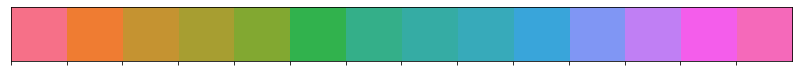

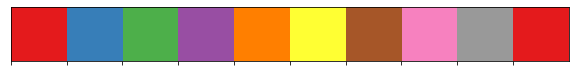

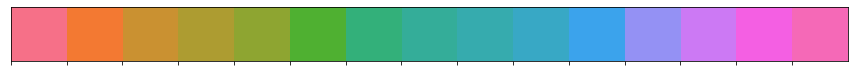

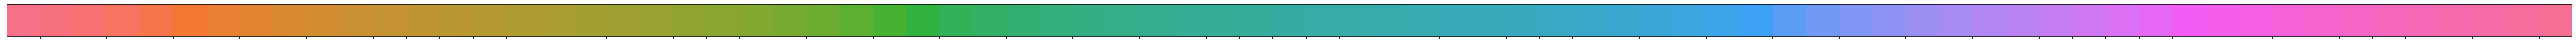

In [5]:
# Set microbe (column) colors
df = agora_tax_df.fillna('')
c = ['phylum', 'gram', 'oxygenstat', 'metabolism']
p = ['husl', 'Set1', 'husl', 'husl']
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
col_colors = [[palettes[i][df.loc[x, c[i]]] for x in df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

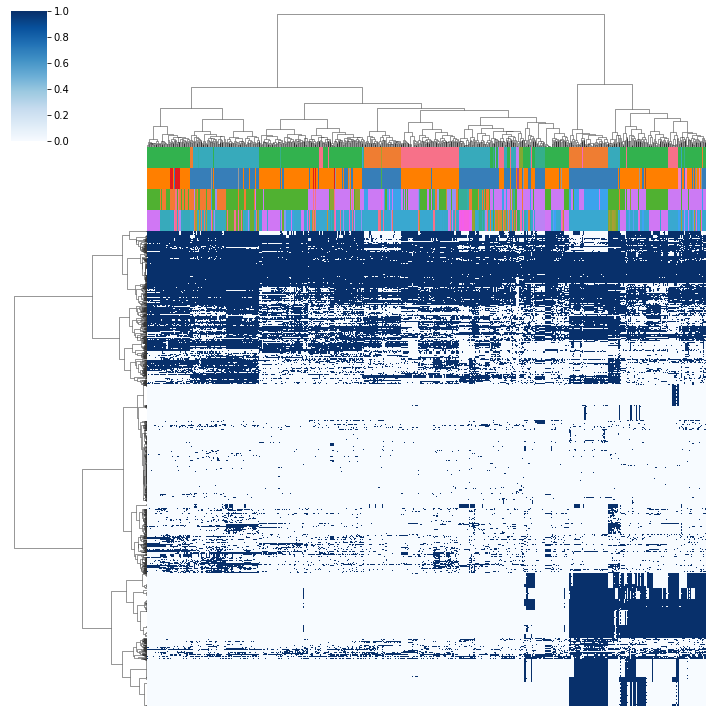

In [6]:
g = sns.clustermap(rxn_df, cmap='Blues', method='ward', xticklabels=False, yticklabels=False, col_colors=col_colors)
g.savefig(join(plot_dir, 'clustermap_agora.png'), bbox_inches='tight')

In [7]:
# Choose suffix indicating whose data is used ("jeleel" or "pabo")
suffix = 'jeleel'

In [8]:
# Load sample data
df = pd.read_csv(data_dir + '/metadata_table_' + suffix + '.csv', index_col=0)
df.columns = [x.lower() for x in df.columns]
sample_df = df.loc[:, df.isna().sum() < 95]
sample_df

,diet,dn,sample_type,fish_number,tank,quant_reading,sample_kind
M1,IWA,5,Digesta,4,1.0,83,True_sample
M10,AWA,6,Digesta,22,4.0,59,True_sample
M11,AWA,6,Digesta,23,4.0,44,True_sample
M12,AWA,6,Digesta,24,4.0,36,True_sample
M13,ACJ,4,Digesta,28,5.0,98,True_sample
...,...,...,...,...,...,...,...
S72,NC,9,control,NC,NaN,1,Negative_control
S8,FM,1,Digesta,14,3.0,74,True_sample
S9,FM,1,Digesta,15,3.0,8,True_sample
M48,mock,7,Positive_control,PC2,NaN,158,True_sample


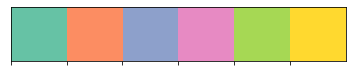

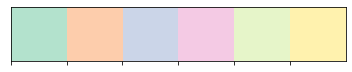

In [9]:
# Define diet order and palette
diet_order = {
    'pabo': ['CD', 'IM', 'DFIM', 'DCIM', 'IO', 'EX'],
    'jeleel': ['FM', 'ICJ', 'ACJ', 'IWA', 'AWA', 'SBM']
}
diet_palette = sns.color_palette('Set2', len(diet_order[suffix]))
diet_palette_pale = sns.color_palette('Pastel2', len(diet_order[suffix]))
sns.palplot(diet_palette)
sns.palplot(diet_palette_pale)

In [10]:
# Get digesta samples
digesta = sample_df.sample_type == 'Digesta'

In [11]:
# Load taxonomy data
df = pd.read_csv(data_dir + '/tax_table_' + suffix + '.csv', index_col=0)
df.columns = [x.lower() for x in df.columns]
tax_df = df
tax_df

,kingdom,phylum,class,order,family,genus,species
TAGGGAATCTTCCACAATGGACGCAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTAAAGAAGAACGTGGGTGAGAGTAACTGTTCACCCAGTGACGGTATTTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTCTTTTAAGTCTAATGTGAAAGCCTTCGGCTCAACCGAAGAAGTGCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Pediococcus,NaN
TAGGGAATCTTCCACAATGGGCGCAAGCCTGATGGAGCAACACCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTGGAGAAGAACGTGCGTGAGAGTAACTGTTCACGCAGTGACGGTATCCAACCAGAAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTGCTTAGGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGGGCATCGGAAACCGGGCGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,HT002,NaN
TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCAATGTCGCGTGAGTGAAGAAGGCCCTTGGGTCGTAAAGCTCTTTTATGGGGGAAGATGATGACGGTACCCCAAGAATAAGCACCGGCTAACTATGTGCCAGCAGCCGCGGTAATACATAGGGTGCGAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGCAGGCGGAATAGTAAGTCGGAGGTGAAAGCCCGGGGCTCAACCCCGGAGGGTCTTTCGAAACTGCTAATCTAGAGAGGGTCAGGGGCCGGCAGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAATACCGGTGGCGAAGGCGGCCGGCTGGGGCCACTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,Bacteria,SAR324 clade(Marine group B),NaN,NaN,NaN,NaN,NaN
TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATGCCGCGTGTGTGAAGAAGGCCTTCGGGTTGTAAAGCACTTTCAGTAGGGAGGAAAGGTAGCAGCTTAATACGCTGTTGCTGTGACGTTACCTACAGAAGAAGGACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTCCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTGTTAAGCGAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTCGAACTGGCGAACTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGCACGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Shewanellaceae,Shewanella,NaN
TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGCCGCGTGAGCGATGAAGGTCTTCGGATCGTAAAGCTCTGTCCTAAGGGAAGATAGTGACGGTACCTTAGGAGGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAACACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGGGTGCGCAGGCGGCCTTGCAAGTCAGATGTGAAAGATTACGGCTTAACCGTGACAAGCATTTGAAACTGTGAGGCTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGTGGTGAAATACGTAGATATTAGGAGGAATACCAGTAGCGAAGGCGGCTCTCTGGACTGCAACTGACGCTGAGGCACGAAAACGTGGGGAGCAAACA,Bacteria,Firmicutes,Clostridia,Peptostreptococcales-Tissierellales,Family XI,Anaerosalibacter,NaN
...,...,...,...,...,...,...,...
TAGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGAGGAAGGCCTTCGGGTCGTAAAGCTCTGTTGTGAGGGAAGAAGCGGTACCGTTCGAATAGGGCGGTACCTTGACGGTACCTCACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCTTCTTAAGTCTGATGTGAAATCTCGGGGCTCAACCCCGAGCGGCCATTGGAAACTGGGGAGCTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,NaN
TCAGGAATCGTGCGCAATGGACGAAAGTCTGACGCCGCGACATCGCGTGGAGGATGAAGGTTCTAGGATCGTAAACTCCTTTTCTCACCGAACAAGTTCTGAGTGTAGGTGAGGAATAAGTACCTGCTAACCACGTGCCAGAAGCATCGGTAATACGTGGGGTACGAGCGTTACCCGGAATTACTGGGCGTAAAGAGATGCGTAGGCGTCTTTTTAAGTCAGCTGTTAAAGCTCACGGCTCAACCGTGAAATCGCAGCTGATACTGAAAGGATTGAGGGAGATAGAGGAGAGTAGAATTCCTGGTGGAGCGGTTAAATGCGTAGATATCAGGAGGAATACCCATGGCGAAGGCAACTCTCTGGATCTCACCTGACGCTAAGGCTCGAAAGCGTGGGGAGCAAAAC,Bacteria,Patescibacteria,Dojkabacteria,NaN,NaN,NaN,NaN
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGATTTCGGTTCGTAAAACTCTGTTGCGAGGGAAGAACAAGTACGAAGTAACTACTCGTACCTTGACGGTACCTCGTTAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTCCTTTAAGTCTGATGTGAAATCCCACGGCTCAACCGTGGAAGGTCATTGGAAACTGGAGGACTTGAGTATAAGAGAGGAAAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGCTTATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,Bacteria,Firmicutes,Bacilli,Bacillales,Planococcaceae,

In [12]:
# Load count data
df = pd.read_csv(data_dir + '/count_table_' + suffix + '.csv', index_col=0)
cnt_df = df
cnt_df

,TAGGGAATCTTCCACAATGGACGCAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTAAAGAAGAACGTGGGTGAGAGTAACTGTTCACCCAGTGACGGTATTTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTCTTTTAAGTCTAATGTGAAAGCCTTCGGCTCAACCGAAGAAGTGCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,TAGGGAATCTTCCACAATGGGCGCAAGCCTGATGGAGCAACACCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTGGAGAAGAACGTGCGTGAGAGTAACTGTTCACGCAGTGACGGTATCCAACCAGAAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTGCTTAGGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGGGCATCGGAAACCGGGCGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCAATGTCGCGTGAGTGAAGAAGGCCCTTGGGTCGTAAAGCTCTTTTATGGGGGAAGATGATGACGGTACCCCAAGAATAAGCACCGGCTAACTATGTGCCAGCAGCCGCGGTAATACATAGGGTGCGAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGCAGGCGGAATAGTAAGTCGGAGGTGAAAGCCCGGGGCTCAACCCCGGAGGGTCTTTCGAAACTGCTAATCTAGAGAGGGTCAGGGGCCGGCAGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAATACCGGTGGCGAAGGCGGCCGGCTGGGGCCACTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATGCCGCGTGTGTGAAGAAGGCCTTCGGGTTGTAAAGCACTTTCAGTAGGGAGGAAAGGTAGCAGCTTAATACGCTGTTGCTGTGACGTTACCTACAGAAGAAGGACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTCCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTGTTAAGCGAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTCGAACTGGCGAACTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGCACGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGCCGCGTGAGCGATGAAGGTCTTCGGATCGTAAAGCTCTGTCCTAAGGGAAGATAGTGACGGTACCTTAGGAGGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAACACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGGGTGCGCAGGCGGCCTTGCAAGTCAGATGTGAAAGATTACGGCTTAACCGTGACAAGCATTTGAAACTGTGAGGCTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGTGGTGAAATACGTAGATATTAGGAGGAATACCAGTAGCGAAGGCGGCTCTCTGGACTGCAACTGACGCTGAGGCACGAAAACGTGGGGAGCAAACA,TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAACTCTGTTGTTAGAGAAGAACGGCTAAGGTAGTAACTGACCTTAGAGTGACGGTATCTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTCACCGGAGAAGATAATGACGGTATCCGGAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATATTTAAGTCAGGGGTGAAATCCCAGAGCTCAACTCTGGAACTGCCTTTGATACTGGGTATCTTGAGTATGGAAGAGGTAAGTGGAATTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAGGAACACCAGTGGCGAAGGCGGCTTACTGGTCCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGCGTGTGTGAAGAAGGCTTTCGGGTTGTAAAGCACTTTCAGCGAGGAGGAAAGGGCATAAGTTAATACCTTATGCCTGTGACGTTACTCGCAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTAATTAAGTCAGATGTGAAATCCCAGGGCTCAACCTTGGAACTGCATTTGAAACTGGTTGACTAGAGTTTTGTAGAGGGTGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCAGTGGCGAAGGCGGCCACCTGGACAAAGACTGACACTGAGGCGCGAAGGCGTGGGGAGCAAACG,TGGGGAATCTTCCGCAATGGGCGCAAGCCTGACGGAGCAATGCCGCGTGAGTGAAGAAGGCCTTCGGGTTGTAAAACTCTGTCCTTATCGAAGAGAGCGTAGTGTAGTAACTGCCATTACGAGGACGGTAGATAAGGAGGAAGCCCCGGCTAACTATGTGCCAGCAGCCGCGGTAAAACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTTTTTTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATGGCACCTGATACTGGAAGACTTGAGTATGGGAGAGGCAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAATACCAGTGGCGAAGGCGGCTTGCTGGACCAAAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAACGATGAAGGCTTTCGGGTCGTAAAGTTCTGTCCTTGGGGAAGATAATGACGGTACCCAAGGAGGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCGAGCGTTGTCCGGATTTATTGGGCGTAAAGGGTTCGCAGGTGGCCTTTTAAGTCAGATGT

Text(0.5, 0, 'Abundance (log10)')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


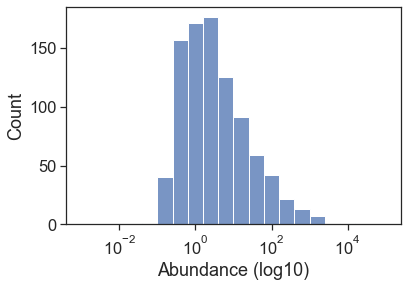

In [13]:
sns.set(style='ticks', font_scale=1.5)
sns.histplot(cnt_df.mean(), bins=20, binrange=(-3, 5), log_scale=True)
plt.xlabel('Abundance (log10)')

In [14]:
# Normalize counts to fraction
frac_df = cnt_df.T / cnt_df.sum(1)
frac_df = frac_df.T
frac_df

,TAGGGAATCTTCCACAATGGACGCAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTAAAGAAGAACGTGGGTGAGAGTAACTGTTCACCCAGTGACGGTATTTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTCTTTTAAGTCTAATGTGAAAGCCTTCGGCTCAACCGAAGAAGTGCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,TAGGGAATCTTCCACAATGGGCGCAAGCCTGATGGAGCAACACCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTGGAGAAGAACGTGCGTGAGAGTAACTGTTCACGCAGTGACGGTATCCAACCAGAAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTGCTTAGGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGGGCATCGGAAACCGGGCGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCAATGTCGCGTGAGTGAAGAAGGCCCTTGGGTCGTAAAGCTCTTTTATGGGGGAAGATGATGACGGTACCCCAAGAATAAGCACCGGCTAACTATGTGCCAGCAGCCGCGGTAATACATAGGGTGCGAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGCAGGCGGAATAGTAAGTCGGAGGTGAAAGCCCGGGGCTCAACCCCGGAGGGTCTTTCGAAACTGCTAATCTAGAGAGGGTCAGGGGCCGGCAGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAATACCGGTGGCGAAGGCGGCCGGCTGGGGCCACTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATGCCGCGTGTGTGAAGAAGGCCTTCGGGTTGTAAAGCACTTTCAGTAGGGAGGAAAGGTAGCAGCTTAATACGCTGTTGCTGTGACGTTACCTACAGAAGAAGGACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTCCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTGTTAAGCGAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTCGAACTGGCGAACTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGCACGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGCCGCGTGAGCGATGAAGGTCTTCGGATCGTAAAGCTCTGTCCTAAGGGAAGATAGTGACGGTACCTTAGGAGGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAACACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGGGTGCGCAGGCGGCCTTGCAAGTCAGATGTGAAAGATTACGGCTTAACCGTGACAAGCATTTGAAACTGTGAGGCTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGTGGTGAAATACGTAGATATTAGGAGGAATACCAGTAGCGAAGGCGGCTCTCTGGACTGCAACTGACGCTGAGGCACGAAAACGTGGGGAGCAAACA,TAGGGAATCTTCGGCAATGGGCGCAAGCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAACTCTGTTGTTAGAGAAGAACGGCTAAGGTAGTAACTGACCTTAGAGTGACGGTATCTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTCACCGGAGAAGATAATGACGGTATCCGGAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATATTTAAGTCAGGGGTGAAATCCCAGAGCTCAACTCTGGAACTGCCTTTGATACTGGGTATCTTGAGTATGGAAGAGGTAAGTGGAATTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAGGAACACCAGTGGCGAAGGCGGCTTACTGGTCCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGCGTGTGTGAAGAAGGCTTTCGGGTTGTAAAGCACTTTCAGCGAGGAGGAAAGGGCATAAGTTAATACCTTATGCCTGTGACGTTACTCGCAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTAATTAAGTCAGATGTGAAATCCCAGGGCTCAACCTTGGAACTGCATTTGAAACTGGTTGACTAGAGTTTTGTAGAGGGTGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCAGTGGCGAAGGCGGCCACCTGGACAAAGACTGACACTGAGGCGCGAAGGCGTGGGGAGCAAACG,TGGGGAATCTTCCGCAATGGGCGCAAGCCTGACGGAGCAATGCCGCGTGAGTGAAGAAGGCCTTCGGGTTGTAAAACTCTGTCCTTATCGAAGAGAGCGTAGTGTAGTAACTGCCATTACGAGGACGGTAGATAAGGAGGAAGCCCCGGCTAACTATGTGCCAGCAGCCGCGGTAAAACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTTTTTTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATGGCACCTGATACTGGAAGACTTGAGTATGGGAGAGGCAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAATACCAGTGGCGAAGGCGGCTTGCTGGACCAAAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAACGATGAAGGCTTTCGGGTCGTAAAGTTCTGTCCTTGGGGAAGATAATGACGGTACCCAAGGAGGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCGAGCGTTGTCCGGATTTATTGGGCGTAAAGGGTTCGCAGGTGGCCTTTTAAGTCAGATGT

Text(0.5, 0, 'Fraction (log10)')

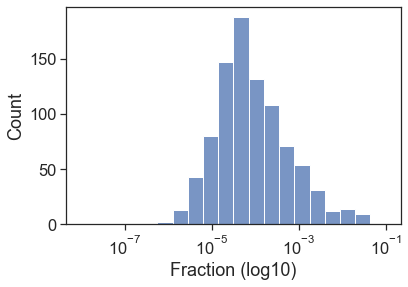

In [15]:
sns.set(style='ticks', font_scale=1.5)
sns.histplot(frac_df.mean(), bins=20, binrange=(-8, -1), log_scale=True)
plt.xlabel('Fraction (log10)')

Text(0, 0.5, 'Fraction (log10)')

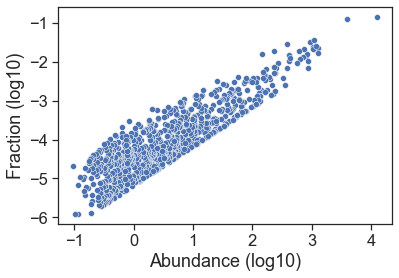

In [16]:
sns.set(style='ticks', font_scale=1.5)
sns.scatterplot(np.log10(cnt_df.mean()), np.log10(frac_df.mean()))
plt.xlabel('Abundance (log10)')
plt.ylabel('Fraction (log10)')

In [17]:
sample_df.nunique()

diet              12
dn                 9
sample_type        5
fish_number      135
tank              18
quant_reading     81
sample_kind        4
dtype: int64

In [18]:
tax_df.nunique()

kingdom      2
phylum      21
class       40
order      101
family     155
genus      284
species    112
dtype: int64

In [19]:
# Choose sample variables and palettes
c = ['diet', 'tank']
p = ['husl', 'Blues']

['Actinobacteriota', 'Armatimonadota', 'Bacteroidota', 'Bdellovibrionota', 'Campylobacterota', 'Chloroflexi', 'Cyanobacteria', 'Deinococcota', 'Dependentiae', 'Desulfobacterota', 'Firmicutes', 'Fusobacteriota', 'Myxococcota', 'NB1-j', 'Patescibacteria', 'Planctomycetota', 'Proteobacteria', 'SAR324 clade(Marine group B)', 'Thermoplasmatota', 'Thermotogota', 'Verrucomicrobiota']
['ACJ', 'AWA', 'FM', 'FP', 'ICJ', 'IWA', 'NC', 'SBM', 'SW', 'TW', 'mock', 'mock_1']
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]


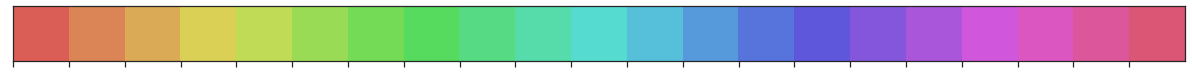

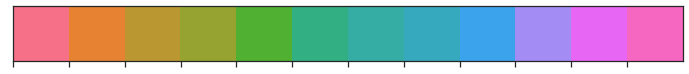

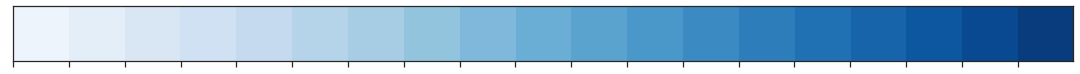

In [20]:
# Set microbe (column) colors
df = tax_df.fillna('')
rank = 'phylum'
palette = dict(zip(sorted(set(df[rank])), sns.color_palette('hls', len(set(df[rank])))))
col_colors = [palette[df.loc[x, rank]] for x in frac_df.columns]

sns.palplot(palette.values())
print(sorted(set(df[rank])))

# Set sample (row) colors
df = sample_df.fillna(0)
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
row_colors = [[palettes[i][df.loc[x, c[i]]] for x in frac_df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

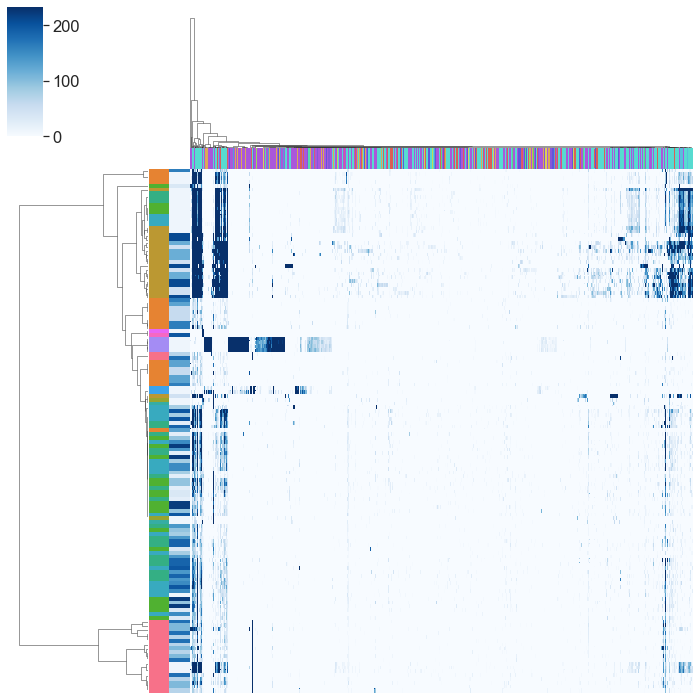

In [21]:
# Clustermap (counts)
g = sns.clustermap(cnt_df, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_cnt_' + suffix + '.png'), bbox_inches='tight')

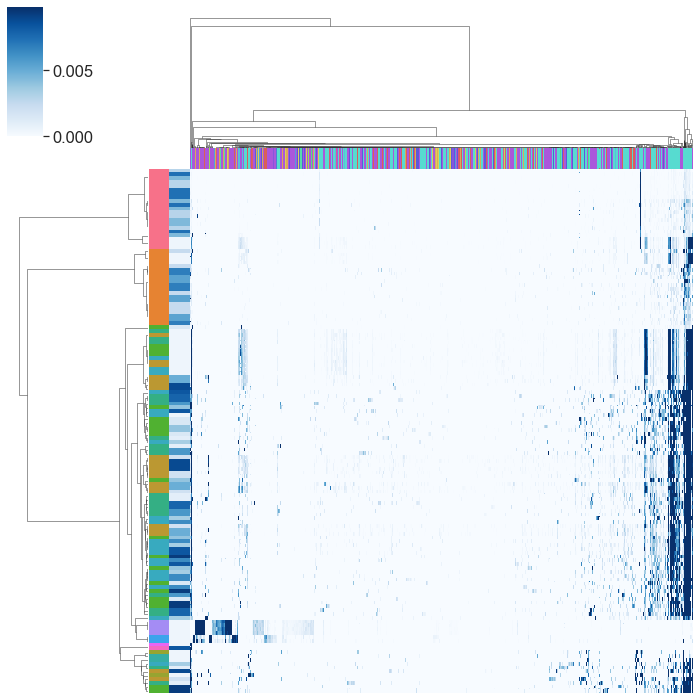

In [22]:
# Clustermap (fractions)
g = sns.clustermap(frac_df, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_frac_' + suffix + '.png'), bbox_inches='tight')

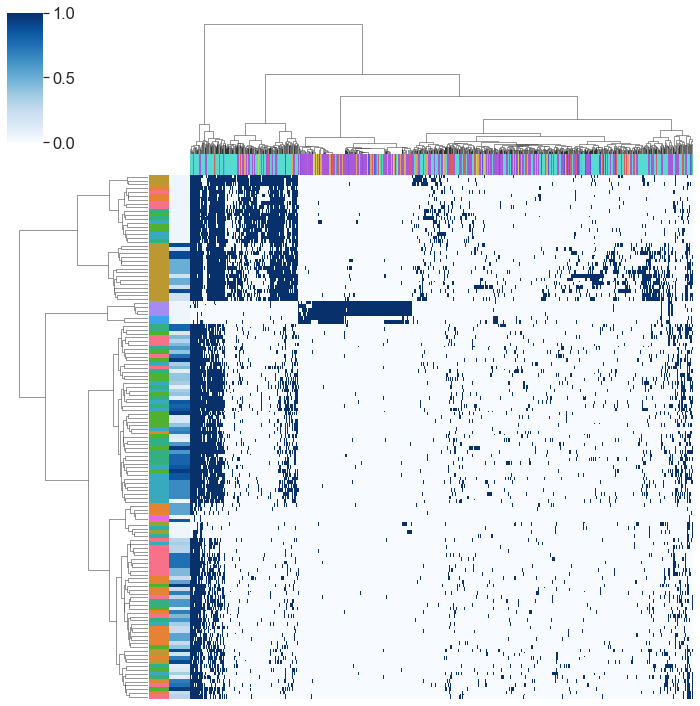

In [23]:
# Clustermap (binary)
g = sns.clustermap(frac_df > 0, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_bin_' + suffix + '.png'), bbox_inches='tight')

In [59]:
# PCA on counts
pca = PCA()
Z = StandardScaler().fit_transform(frac_df[digesta])
T = pca.fit_transform(Z)
T.shape

(107, 107)

In [60]:
n = 5
sample_df.loc[digesta, ['pc' + str(x + 1) for x in range(n)]] = T[:, :n]
sample_df

,diet,dn,sample_type,fish_number,tank,quant_reading,sample_kind,pc1,pc2,pc3,pc4,pc5
M1,IWA,5,Digesta,4,1.0,83,True_sample,1.334344,-3.191450,-3.467378,-1.003424,1.606185
M10,AWA,6,Digesta,22,4.0,59,True_sample,-6.251562,2.311301,-1.283363,0.873673,-0.791131
M11,AWA,6,Digesta,23,4.0,44,True_sample,-6.840947,2.999256,-0.932596,0.633869,-0.438247
M12,AWA,6,Digesta,24,4.0,36,True_sample,-7.514118,3.621647,-0.680338,0.602230,-0.547642
M13,ACJ,4,Digesta,28,5.0,98,True_sample,-8.274040,4.006070,-0.746051,0.807753,-0.622098
...,...,...,...,...,...,...,...,...,...,...,...,...
S72,NC,9,control,NC,NaN,1,Negative_control,NaN,NaN,NaN,NaN,NaN
S8,FM,1,Digesta,14,3.0,74,True_sample,7.586921,5.065708,1.939734,-3.117451,5.177320
S9,FM,1,Digesta,15,3.0,8,True_sample,0.401909,-8.123483,26.609346,29.439193,11.402787
M48,mock,7,Positive_control,PC2,NaN,158,True_sample,NaN,NaN,NaN,NaN,NaN


No handles with labels found to put in legend.


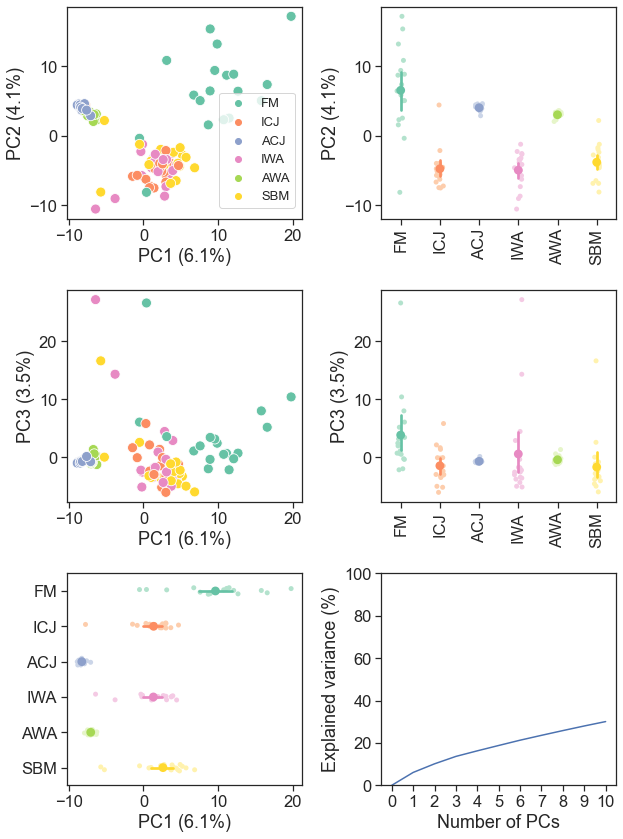

In [61]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = sample_df[digesta]
order = diet_order[suffix]

plt.subplot(3, 2, 1)
ax = sns.scatterplot(x=df.pc1, y=df.pc2, hue=df.diet, hue_order=order, palette=diet_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
# ax.legend().set_visible(False)
ax.legend(ncol=1, fontsize=13, loc=(0.65, 0.05)).set_title(None)

plt.subplot(3, 2, 2)
ax = sns.pointplot(x=df.diet, y=df.pc2, join=False, palette=diet_palette, orient='v', order=order)
ax = sns.stripplot(x=df.diet, y=df.pc2, palette=diet_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('')
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend().set_visible(False)

plt.subplot(3, 2, 3)
ax = sns.scatterplot(x=df.pc1, y=df.pc3, hue=df.diet, hue_order=order, palette=diet_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.legend().set_visible(False)

plt.subplot(3, 2, 4)
ax = sns.pointplot(x=df.diet, y=df.pc3, join=False, palette=diet_palette, orient='v', order=order)
ax = sns.stripplot(x=df.diet, y=df.pc3, palette=diet_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_yticklabels([])

plt.subplot(3, 2, 5)
ax = sns.pointplot(y=df.diet, x=df.pc1, join=False, palette=diet_palette, orient='h', order=order)
ax = sns.stripplot(y=df.diet, x=df.pc1, palette=diet_palette_pale, zorder=-1, orient='h', order=order)
plt.ylabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))

plt.subplot(3, 2, 6)
n = 10
x = [0]
x.extend(range(1, n + 1))
y = [0]
y.extend(100 * np.cumsum(pca.explained_variance_ratio_[:n]))
ax = sns.lineplot(x, y)
plt.ylim(0, 100)
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance (%)')
ax.set_xticks(range(n + 1))
ax.set_xticklabels(range(n + 1))


f.set_size_inches(9, 12)
plt.tight_layout()
f.savefig(join(plot_dir, 'pca_cnt_' + suffix + '.svg'), bbox_inches='tight')

In [27]:
# Map samples to models (fast)

mapping = {}
matches = []
models = []

for i, row in tax_df.iterrows():
    if row.family == np.nan or row.family not in set(agora_tax_df.family):
        matches.append(np.nan)
        models.append(0)
        continue
    
    df = agora_tax_df[agora_tax_df.family == row.family]
    m = 'family'
    for rank in ('genus', 'species'):
        if row[rank] in set(df[rank]):
            df = df[df[rank] == row[rank]]
            m = rank
    
    mapping[row.name] = list(df.index)
    matches.append(m.capitalize())
    models.append(len(df))

tax_df['match'] = matches
tax_df['models'] = models
tax_df

,kingdom,phylum,class,order,family,genus,species,match,models
TAGGGAATCTTCCACAATGGACGCAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTAAAGAAGAACGTGGGTGAGAGTAACTGTTCACCCAGTGACGGTATTTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTCTTTTAAGTCTAATGTGAAAGCCTTCGGCTCAACCGAAGAAGTGCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Pediococcus,NaN,Genus,3
TAGGGAATCTTCCACAATGGGCGCAAGCCTGATGGAGCAACACCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTGGAGAAGAACGTGCGTGAGAGTAACTGTTCACGCAGTGACGGTATCCAACCAGAAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTGCTTAGGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGGGCATCGGAAACCGGGCGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,HT002,NaN,Family,52
TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCAATGTCGCGTGAGTGAAGAAGGCCCTTGGGTCGTAAAGCTCTTTTATGGGGGAAGATGATGACGGTACCCCAAGAATAAGCACCGGCTAACTATGTGCCAGCAGCCGCGGTAATACATAGGGTGCGAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGCAGGCGGAATAGTAAGTCGGAGGTGAAAGCCCGGGGCTCAACCCCGGAGGGTCTTTCGAAACTGCTAATCTAGAGAGGGTCAGGGGCCGGCAGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAATACCGGTGGCGAAGGCGGCCGGCTGGGGCCACTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,Bacteria,SAR324 clade(Marine group B),NaN,NaN,NaN,NaN,NaN,NaN,0
TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATGCCGCGTGTGTGAAGAAGGCCTTCGGGTTGTAAAGCACTTTCAGTAGGGAGGAAAGGTAGCAGCTTAATACGCTGTTGCTGTGACGTTACCTACAGAAGAAGGACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTCCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTGTTAAGCGAGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTTCGAACTGGCGAACTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGCACGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Shewanellaceae,Shewanella,NaN,NaN,0
TGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGCCGCGTGAGCGATGAAGGTCTTCGGATCGTAAAGCTCTGTCCTAAGGGAAGATAGTGACGGTACCTTAGGAGGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAACACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGGGTGCGCAGGCGGCCTTGCAAGTCAGATGTGAAAGATTACGGCTTAACCGTGACAAGCATTTGAAACTGTGAGGCTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGTGGTGAAATACGTAGATATTAGGAGGAATACCAGTAGCGAAGGCGGCTCTCTGGACTGCAACTGACGCTGAGGCACGAAAACGTGGGGAGCAAACA,Bacteria,Firmicutes,Clostridia,Peptostreptococcales-Tissierellales,Family XI,Anaerosalibacter,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
TAGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGAGGAAGGCCTTCGGGTCGTAAAGCTCTGTTGTGAGGGAAGAAGCGGTACCGTTCGAATAGGGCGGTACCTTGACGGTACCTCACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCTTCTTAAGTCTGATGTGAAATCTCGGGGCTCAACCCCGAGCGGCCATTGGAAACTGGGGAGCTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,NaN,Genus,27
TCAGGAATCGTGCGCAATGGACGAAAGTCTGACGCCGCGACATCGCGTGGAGGATGAAGGTTCTAGGATCGTAAACTCCTTTTCTCACCGAACAAGTTCTGAGTGTAGGTGAGGAATAAGTACCTGCTAACCACGTGCCAGAAGCATCGGTAATACGTGGGGTACGAGCGTTACCCGGAATTACTGGGCGTAAAGAGATGCGTAGGCGTCTTTTTAAGTCAGCTGTTAAAGCTCACGGCTCAACCGTGAAATCGCAGCTGATACTGAAAGGATTGAGGGAGATAGAGGAGAGTAGAATTCCTGGTGGAGCGGTTAAATGCGTAGATATCAGGAGGAATACCCATGGCGAAGGCAACTCTCTGGATCTCACCTGACGCTAAGGCTCGAAAGCGTGGGGAGCAAAAC,Bacteria,Patescibacteria,Dojkabacteria,NaN,NaN,NaN,NaN,NaN,0
TAGGGAATCTTCCACAATGGACGAAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGATTTCGGTTCGTAAAACTCTGTTGCGAGGGAAGAACAAGTACGAAGTAACTACTCGTACCTTGACGGTACCTCGTTAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTCCTTTAAGTCTGATGTGAAATCCCACGGCTCAACCGTGGAAGGTCATTGGAAACTGGAGGACTTGAGTATAAGAGAGGAAAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGCTTATTACTGACGCTGAGGCGCGAA

In [66]:
sns.set(font_scale=1.5, style='ticks')
df = tax_df
df = df.sort_values(by='match')

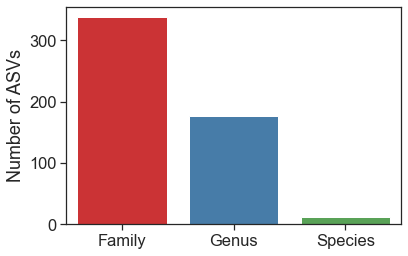

In [67]:
# Plot taxonomic level of match for each ASV
f = plt.figure()

ax = sns.countplot(df.match, palette='Set1')

plt.xlabel('Taxonomic level of model match')
plt.xlabel('')
plt.ylabel('Number of ASVs')

f.savefig(join(plot_dir, 'match_level_asv_' + suffix + '.svg'), bbox_inches='tight')

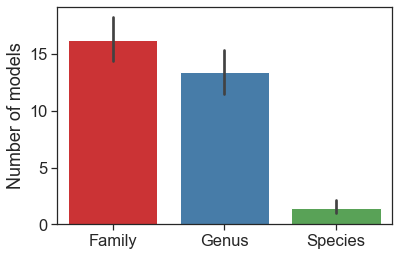

In [68]:
# Plot number of models mapped to each ASV by taxonomic level of match
f = plt.figure()

df = df[df.models > 0]
ax = sns.barplot(df.match, df.models, palette='Set1')

plt.xlabel('')
plt.ylabel('Number of models')

f.savefig(join(plot_dir, 'match_level_models_' + suffix + '.svg'), bbox_inches='tight')

In [31]:
# Get fraction of models containing each reaction for each ASV
d = {}
for k, models in mapping.items():
    d[k] = rxn_df.iloc[:, models].mean(1)
asv_rxn_df = pd.DataFrame(d)
asv_rxn_df.to_csv(data_dir + '/asv_reactions_' + suffix + '.csv')
asv_rxn_df

,TAGGGAATCTTCCACAATGGACGCAAGTCTGATGGAGCAACGCCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTAAAGAAGAACGTGGGTGAGAGTAACTGTTCACCCAGTGACGGTATTTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTCTTTTAAGTCTAATGTGAAAGCCTTCGGCTCAACCGAAGAAGTGCATTGGAAACTGGGAGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,TAGGGAATCTTCCACAATGGGCGCAAGCCTGATGGAGCAACACCGCGTGAGTGAAGAAGGGTTTCGGCTCGTAAAGCTCTGTTGTTGGAGAAGAACGTGCGTGAGAGTAACTGTTCACGCAGTGACGGTATCCAACCAGAAAGTCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTGCTTAGGTCTGATGTGAAAGCCTTCGGCTTAACCGAAGAAGGGCATCGGAAACCGGGCGACTTGAGTGCAGAAGAGGACAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACA,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTCACCGGAGAAGATAATGACGGTATCCGGAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATATTTAAGTCAGGGGTGAAATCCCAGAGCTCAACTCTGGAACTGCCTTTGATACTGGGTATCTTGAGTATGGAAGAGGTAAGTGGAATTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAGGAACACCAGTGGCGAAGGCGGCTTACTGGTCCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGCGTGTGTGAAGAAGGCCTTCGGGTTGTAAAGCACTTTCAGCGGGGAGGAAGGCGATAAGGTTAATAACCTTGTCGATTGACGTTACCCGCAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACA,TGGGGAATTTTGGACAATGGGGGCAACCCTGATCCAGCAATGCCGCGTGAGTGAAGAAGGCCTTCGGGTTGTAAAGCTCTTTTGTCAGGGAAGAAACGGTAGTAGCGAATAACTATTACTAATGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTGTGTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAATTGCATTTGAGACTGCACGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGATATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,TGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCAATGCCGCGTGAGTGAAGAAGGCCTTCGGGTTGTAAAGCTCTTTTGTCAGGGAAGAAACGGTGGTGGTTAATACCTGCTGCTAATGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATATAAGACAGTCGTGAAATCCCCGGGCTCAACCTGGGAACTGCGATTGTGACTGTATGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGATATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,TGGGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGCGTGTGTGATGAAGGCCTTAGGGTCGTAAAGCACTTTCGCCAGGGATGATAATGACAGTACCTGGTAAAGAAACCCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGATCAGAAAGTAGGGGGTGAAATCCCGAGGCTCAACCTCGGAACTGCCTCCTAAACTCCTGGTCTTGAGTTCGAGAGAGGTGAGTGGAATTCCAAGTGTAGAGGTGAAATTCGTAGATATTTGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGTGTGGGGAGCAAACA,TGGGGAATCTTAGACAATGGGGGAAACCCTGATCTAGCGATGCCGCGTGTGTGACGAAGGCCTTAGGGTCGTAAAGCACTTTCGCCAAGGATGATAATGACAGTACTTGGTAAAGAAACCCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGACTATTAAGTAGAGGGTGAAATCCCAGGGCTCAACCCTGGAACTGCCTTCTATACTGGTAGTCTTGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,TGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCAATGCCGCGTGAGTGAAGAAGGCCTTCGGGTTGTAAAGCTCTTTTGTCAGGGAAGAAACGGTGGGAGCTAATATCTCCCGCTAATGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGTCTGACGTGAAAGCCCCGGGCTCAACCTGGGAATTGCGTTGGAGACTGCAAGGCTTGAATCTGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCGATGGCGAAGGCAGCCCCCTGGGTCAAGATTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,TAGGGAATCTTCCACAATGGGCGAAAGCCTGATGGAGCAATGCCGCGTGAGTGATGAAGGTTTTCGGATCGTAAAGCTCTGTTGCCAGGGAAGAACGTCCAGGTGAGTAACTGCACCTGGAGTGACGGTACCTGAGAAGAAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCG

In [32]:
# Calculate and save reaction abundances
rxn_cnt_df = cnt_df[asv_rxn_df.columns] @ asv_rxn_df.T
rxn_frac_df = frac_df[asv_rxn_df.columns] @ asv_rxn_df.T
rxn_cnt_df.T.to_csv(data_dir + '/reaction_counts_' + suffix + '.csv')
rxn_frac_df.T.to_csv(data_dir + '/reaction_frac_' + suffix + '.csv')

In [33]:
# Choose sample variables and palettes
c = ['diet', 'tank']
p = ['husl', 'Blues']

['ACJ', 'AWA', 'FM', 'FP', 'ICJ', 'IWA', 'NC', 'SBM', 'SW', 'TW', 'mock', 'mock_1']
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]


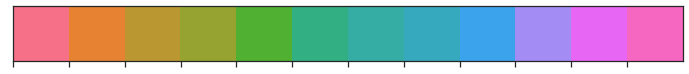

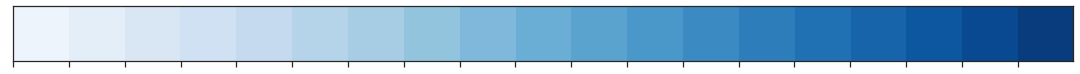

In [34]:
# Set sample (row) colors
df = sample_df.fillna(0)
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
row_colors = [[palettes[i][df.loc[x, c[i]]] for x in rxn_frac_df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

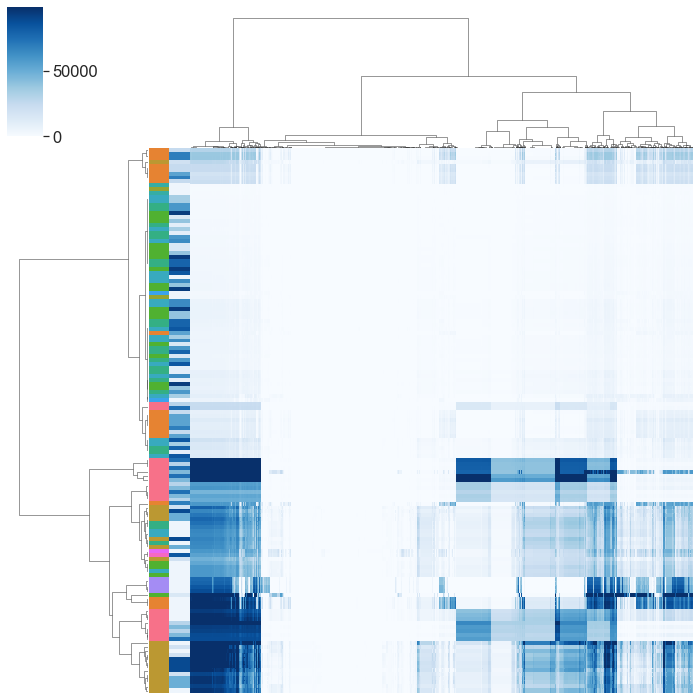

In [35]:
g = sns.clustermap(rxn_cnt_df, cmap='Blues', method='ward', xticklabels=False, yticklabels=False, robust=True, row_colors=row_colors)
g.savefig(join(plot_dir, 'clustermap_rxn_cnt_' + suffix + '.png'), bbox_inches='tight')

In [62]:
# PCA on reaction abundances
pca = PCA()
Z = StandardScaler().fit_transform(rxn_frac_df[digesta])
T = pca.fit_transform(Z)
T.shape

(107, 107)

In [63]:
n = 5
sample_df.loc[digesta, ['pc' + str(x + 1) for x in range(n)]] = T[:, :n]
sample_df

,diet,dn,sample_type,fish_number,tank,quant_reading,sample_kind,pc1,pc2,pc3,pc4,pc5
M1,IWA,5,Digesta,4,1.0,83,True_sample,-0.507446,-15.347468,-9.542927,8.861036,7.002647
M10,AWA,6,Digesta,22,4.0,59,True_sample,-56.897187,60.619925,-10.202551,-6.469152,-0.262111
M11,AWA,6,Digesta,23,4.0,44,True_sample,-60.853524,67.962580,-7.170730,-8.880400,2.953612
M12,AWA,6,Digesta,24,4.0,36,True_sample,-65.176029,74.118981,-8.982099,-8.672585,1.153637
M13,ACJ,4,Digesta,28,5.0,98,True_sample,90.401032,42.623138,7.965092,-1.733465,-2.351605
...,...,...,...,...,...,...,...,...,...,...,...,...
S72,NC,9,control,NC,NaN,1,Negative_control,NaN,NaN,NaN,NaN,NaN
S8,FM,1,Digesta,14,3.0,74,True_sample,15.414252,-26.850822,-29.591307,2.984801,12.737045
S9,FM,1,Digesta,15,3.0,8,True_sample,-21.757690,-44.363589,32.739018,-5.944513,-25.078850
M48,mock,7,Positive_control,PC2,NaN,158,True_sample,NaN,NaN,NaN,NaN,NaN


No handles with labels found to put in legend.


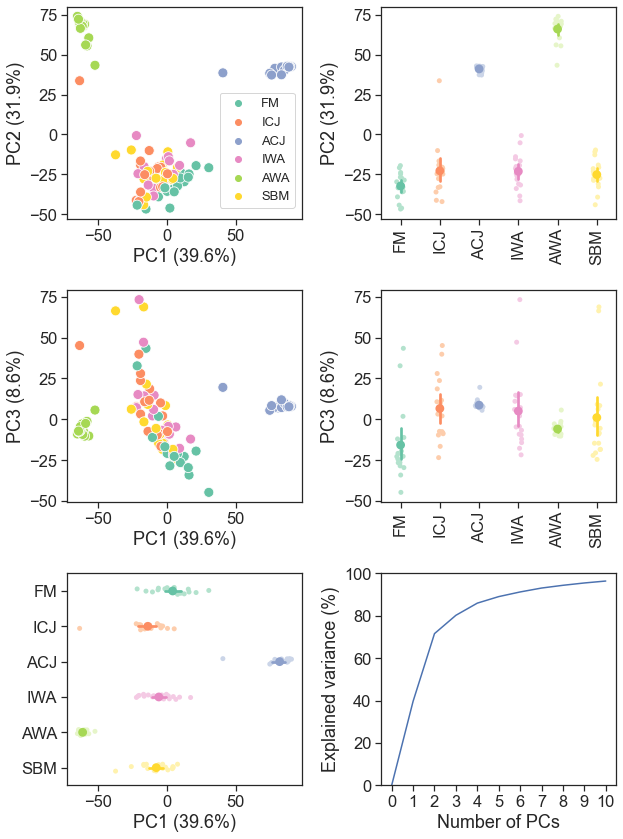

In [64]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = sample_df[digesta]
order = diet_order[suffix]

plt.subplot(3, 2, 1)
ax = sns.scatterplot(x=df.pc1, y=df.pc2, hue=df.diet, hue_order=order, palette=diet_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
# ax.legend().set_visible(False)
ax.legend(ncol=1, fontsize=13, loc=(0.65, 0.05)).set_title(None)

plt.subplot(3, 2, 2)
ax = sns.pointplot(x=df.diet, y=df.pc2, join=False, palette=diet_palette, orient='v', order=order)
ax = sns.stripplot(x=df.diet, y=df.pc2, palette=diet_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('')
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend().set_visible(False)

plt.subplot(3, 2, 3)
ax = sns.scatterplot(x=df.pc1, y=df.pc3, hue=df.diet, hue_order=order, palette=diet_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.legend().set_visible(False)

plt.subplot(3, 2, 4)
ax = sns.pointplot(x=df.diet, y=df.pc3, join=False, palette=diet_palette, orient='v', order=order)
ax = sns.stripplot(x=df.diet, y=df.pc3, palette=diet_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_yticklabels([])

plt.subplot(3, 2, 5)
ax = sns.pointplot(y=df.diet, x=df.pc1, join=False, palette=diet_palette, orient='h', order=order)
ax = sns.stripplot(y=df.diet, x=df.pc1, palette=diet_palette_pale, zorder=-1, orient='h', order=order)
plt.ylabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))

plt.subplot(3, 2, 6)
n = 10
x = [0]
x.extend(range(1, n + 1))
y = [0]
y.extend(100 * np.cumsum(pca.explained_variance_ratio_[:n]))
ax = sns.lineplot(x, y)
plt.ylim(0, 100)
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance (%)')
ax.set_xticks(range(n + 1))
ax.set_xticklabels(range(n + 1))


f.set_size_inches(9, 12)
plt.tight_layout()
f.savefig(join(plot_dir, 'pca_rxn_' + suffix + '.svg'), bbox_inches='tight')

In [39]:
# Choose multiple testing correction method
method = 'fdr_bh'

In [40]:
# Pairwise comparison of diets for each reaction

d = defaultdict(list)
df = sample_df[digesta]

for x1, x2 in combinations(diet_order[suffix], 2):
    print(x1, x2)
    for r in rxn_frac_df.columns:
        if r.startswith('EX_') or r.startswith('sink_') or r.startswith('DM_') or r.startswith('biomass'):
            continue
        
        s = subsys[r]
        if not s or s.startswith('Transport') or s.startswith('Exchange') or s.startswith('Unassigned'):
            continue

        s1 = rxn_frac_df.loc[df[df.diet == x1].index, r]
        s2 = rxn_frac_df.loc[df[df.diet == x2].index, r]
        t, p = ttest_ind(s1, s2, equal_var=False)
        d['x1'].append(x1)
        d['x2'].append(x2)
        d['t'].append(t)
        d['p'].append(p)
        d['reaction'].append(r)
        d['subsys'].append(s)
        
rxn_comp_df = pd.DataFrame(d).dropna()

rxn_comp_df

FM ICJ
FM ACJ
FM IWA
FM AWA
FM SBM
ICJ ACJ
ICJ IWA
ICJ AWA
ICJ SBM
ACJ IWA
ACJ AWA
ACJ SBM
IWA AWA
IWA SBM
AWA SBM


,x1,x2,t,p,reaction,subsys
0,FM,ICJ,-3.269304,0.003248,23DHMPO,"Valine, leucine, and isoleucine metabolism"
1,FM,ICJ,-1.320924,0.195571,26DAPLLAT,Lysine metabolism
2,FM,ICJ,-3.269304,0.003248,2AHBUTI,"Valine, leucine, and isoleucine metabolism"
3,FM,ICJ,1.019047,0.315406,2MBCOATA,Glycerophospholipid metabolism
4,FM,ICJ,1.022915,0.313600,3HAD10M12,Fatty acid synthesis
...,...,...,...,...,...,...
52428,AWA,SBM,-1.220174,0.239015,L2AADIPADOR,Lysine metabolism
52429,AWA,SBM,-1.220174,0.239015,L2AADIPADOR2,Lysine metabolism
52430,AWA,SBM,-1.220174,0.239015,r0594,Lysine metabolism
52431,AWA,SBM,-2.018777,0.057614,SQLE,Cholesterol metabolism


In [41]:
# Correct for multiple testing and save
alpha = 0.05
rxn_comp_df['padj'] = multipletests(rxn_comp_df.p, method=method)[1]
rxn_comp_df.to_csv(data_dir + '/reaction_comp.csv')
(rxn_comp_df.padj < alpha).sum()

34326

In [42]:
# Subsystem enrichment analysis (Fisher's exact test)

dd = defaultdict(list)

for x, df in rxn_comp_df.groupby(['x1', 'x2']):
    for s in sorted(set(df.subsys)):
        a = ((df.subsys == s) & (df.padj <= alpha)).sum()
        b = ((df.subsys != s) & (df.padj <= alpha)).sum()
        c = ((df.subsys == s) & (df.padj > alpha)).sum()
        d = ((df.subsys != s) & (df.padj > alpha)).sum()
        n = a + b + c + d
        
        r, p = fisher_exact([[a, b], [c, d]], alternative='greater')
        
        dd['x1'].append(x[0])
        dd['x2'].append(x[1])
        dd['subsys'].append(s)
        dd['a'].append(a)
        dd['b'].append(b)
        dd['c'].append(c)
        dd['d'].append(d)
        dd['n'].append(n)
        dd['r'].append(r)
        dd['p'].append(p)
        
        if p <= alpha:
            print(x, s, p)
            print(a, b, c, d)
        
subsys_comp_df = pd.DataFrame(dd)

subsys_comp_df

('ACJ', 'AWA') Folate metabolism 0.010877634091175913
38 3012 0 383
('ACJ', 'AWA') Methionine and cysteine metabolism 0.03501105937271721
43 3007 1 382
('ACJ', 'AWA') Mucin O-glycan degradation 8.855383174420287e-52
1072 1978 10 373
('ACJ', 'AWA') Pyrimidine synthesis 0.04561279773414049
26 3024 0 383
('ACJ', 'IWA') Cell wall biosynthesis 0.028885737741545955
90 3216 0 131
('ACJ', 'IWA') Glycerophospholipid metabolism 0.0026444372933516393
250 3056 2 129
('ACJ', 'IWA') Mucin O-glycan degradation 9.57185606870013e-23
1082 2224 0 131
('ACJ', 'SBM') Bile acid metabolism 0.04228490666979074
44 3157 0 237
('ACJ', 'SBM') Cell wall biosynthesis 0.0014792314666555646
90 3111 0 237
('ACJ', 'SBM') Mucin O-glycan degradation 2.403486772488836e-41
1082 2119 0 237
('ACJ', 'SBM') Nucleotide interconversion 0.034943887946643895
93 3108 2 235
('AWA', 'SBM') Glycerophospholipid metabolism 0.0007716661955757416
249 3031 2 148
('AWA', 'SBM') Mucin O-glycan degradation 4.307874806256851e-26
1082 2198 0 15

,x1,x2,subsys,a,b,c,d,n,r,p
0,ACJ,AWA,Alanine and aspartate metabolism,17,3033,3,380,3433,0.709968,0.823273
1,ACJ,AWA,Alkaloid synthesis,1,3049,0,383,3433,inf,0.888436
2,ACJ,AWA,Aminobenzoate degradation,3,3047,0,383,3433,inf,0.701181
3,ACJ,AWA,Aminophosphonate metabolism,1,3049,0,383,3433,inf,0.888436
4,ACJ,AWA,Aminosugar metabolism,23,3027,4,379,3433,0.719937,0.824299
...,...,...,...,...,...,...,...,...,...,...
1435,IWA,SBM,Vitamin B6 metabolism,1,559,16,2854,3430,0.319097,0.952069
1436,IWA,SBM,Vitamin C metabolism,0,560,1,2869,3430,0.000000,1.000000
1437,IWA,SBM,Wood-Ljungdahl Pathway,0,560,6,2864,3430,0.000000,1.000000
1438,IWA,SBM,beta-Alanine metabolism,0,560,8,2862,3430,0.000000,1.000000


In [43]:
# Correct for multiple testing and save
alpha = 0.05
subsys_comp_df['padj'] = multipletests(subsys_comp_df.p, method=method)[1]
subsys_comp_df.to_csv(data_dir + '/subsys_comp.csv')
(subsys_comp_df.padj < alpha).sum()

26

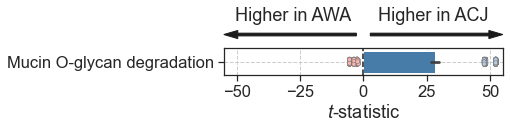

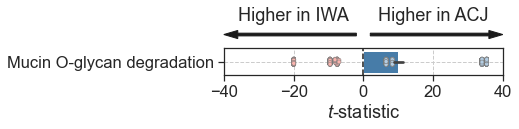

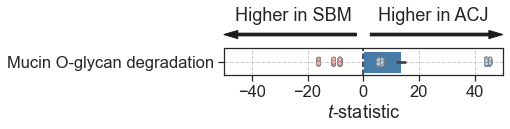

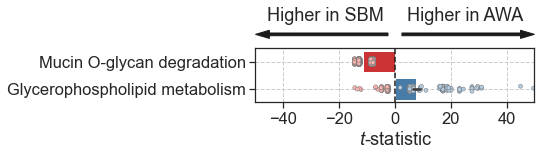

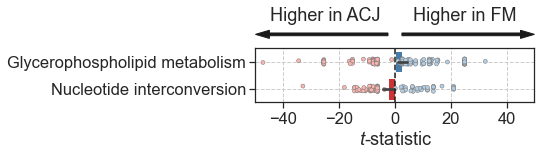

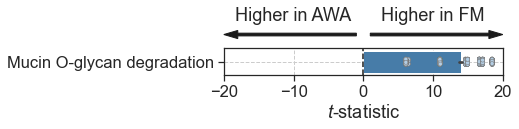

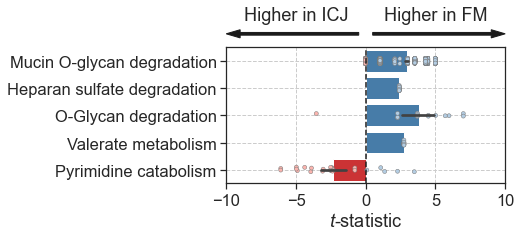

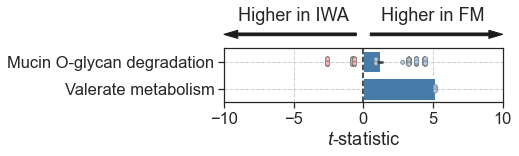

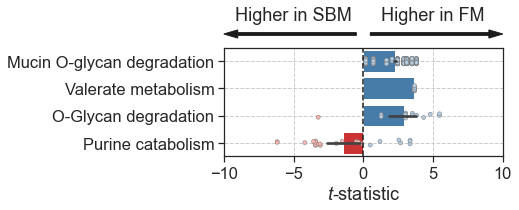

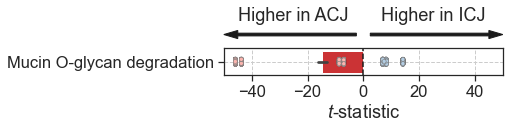

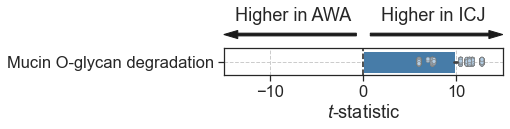

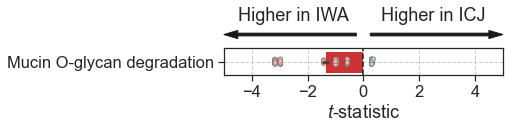

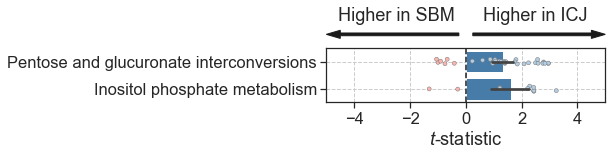

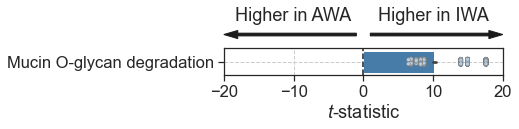

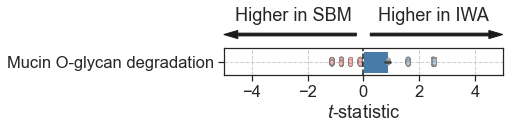

In [57]:
# Plot t-statistic for each reaction, significant subsystem, and diet pair
sns.set(style='ticks', font_scale=1.5)

alpha = 0.05

for x, df in rxn_comp_df.dropna().groupby(['x1', 'x2']): 
#     df = df[(df.subsys != '') & (df.padj < alpha)]
    df = df[(df.subsys != '')]
    
    ss_df = subsys_comp_df
    ss_df = ss_df[(ss_df.x1 == x[0]) & (ss_df.x2 == x[1]) & (ss_df.padj <= alpha)]
    ss = set(ss_df.subsys)
    
    df = df[df.subsys.isin(ss)]
    
    if df.empty:
        continue
    
    f = plt.figure()
    
    xmax = df.t.abs().max()
    xmax = np.ceil(df.t.abs().max() / 5) * 5
    xlim = -xmax, xmax
    ylim = df.subsys.nunique() - 0.5, -0.5
        
#     s = df[df.t < 0].subsys.value_counts().sort_values(ascending=False)
#     ax = plt.barh(y=s.index, width=-s.values)

#     s = df[df.t > 0].subsys.value_counts().sort_values(ascending=False)
#     plt.barh(y=s.index, width=s.values)
    t_mean = df.groupby('subsys').t.mean()
    order = list(t_mean.sort_values(ascending=True).index)
    hue = [dict(t_mean > 0)[x] for x in df.subsys] 
    
    p1 = sns.color_palette('Pastel1', 2)
    p2 = sns.color_palette('Set1', 2)
    if df.t.max() < 0:
        p1.pop()
    elif df.t.min() > 0:
        p1.pop(0)
    if t_mean.max() < 0:
        p2.pop()
    elif t_mean.min() > 0:
        p2.pop(0)
        
#     hue = df.t < 0
#     hue = df.t != 0
    
#     ss_df['recall'] = ss_df.a / ss_df[['a', 'c']].sum(1)
#     ss_df = ss_df.sort_values(by='recall', ascending=True)
#     order = ss_df.subsys
    order = ss_df.sort_values(by='padj', ascending=True).subsys

#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj < alpha], hue=hue, palette='Set1', color='#b3cde3', size=4, order=order, jitter=jitter, zorder=1)
#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj > alpha], color='#f2f2f2', size=4, order=order, jitter=jitter, zorder=1)
#     ax = sns.swarmplot(x=df.t, y=df.subsys, hue=df.padj < alpha, palette=['#999999', '#e41a1c'], size=2, order=order)
#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj < alpha], color='#e41a1c', size=5, order=order)
#     ax = sns.swarmplot(x=df.t, y=df.subsys, hue=df.padj < alpha, order=order, palette=['#d9d9d9', '#e41a1c'], size=2)
#     ax = sns.pointplot(x=df.t, y=df.subsys, order=order, join=False, color='#377eb8')
    ax = sns.stripplot(x=df.t, y=df.subsys, hue=df.t > 0, palette=p1, jitter=0.1, order=order, size=4, zorder=2, linewidth=0.5)
#     ax = sns.pointplot(x=df.t, y=df.subsys, order=order, join=False, color='#377eb8', ci=95, zorder=2)
    ax = sns.barplot(x=df.t, y=df.subsys, hue=hue, palette=p2, order=order, dodge=False, ci=95, zorder=1)
    
    plt.plot([0, 0], ylim, c='k', ls='--')
    
    plt.arrow(-0.05 * xmax, -1, -0.95 * xmax, 0, color='k', clip_on=False, width=0.1, length_includes_head=True, head_length=0.1 * xmax)
    plt.arrow(0.05 * xmax, -1, 0.95 * xmax, 0, color='k', clip_on=False, width=0.1, length_includes_head=True, head_length=0.1 * xmax)
    plt.text(-xmax / 2, -1.5, 'Higher in {}'.format(x[1]), ha='center')
    plt.text(xmax / 2, -1.5, 'Higher in {}'.format(x[0]), ha='center')

#     plt.title(' vs. '.join(x))
    plt.xlabel('Subsystem difference')
    plt.xlabel('$t$-statistic')
    plt.ylabel('')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True, ls='--')
    ax.legend().set_visible(False)
    
#     plt.subplot(1, 6, 4)
#     ax = plt.barh(y=ss_df.subsys, width=ss_df.recall, tick_label='')
    
    f.set_size_inches(5, len(set(df.subsys)) / 2)
    f.savefig(join(plot_dir, '_'.join(x).lower() + '_subsys_diff_' + suffix + '.svg'), bbox_inches='tight')
#     break

In [55]:
# Compute mean t-statistic for each significant subsystem
d = defaultdict(dict)
alpha = 0.05
order = diet_order[suffix]
for (x1, x2), df in rxn_comp_df.groupby(['x1', 'x2']):
    ss_df = subsys_comp_df
    ss_df = ss_df[(ss_df.x1 == x1) & (ss_df.x2 == x2) & (ss_df.padj <= alpha)]
    df = df[df.subsys.isin(set(ss_df.subsys))]
    if df.empty:
        continue
    for ss in df.subsys:
        d[(x1, x2)][ss] = df[df.subsys == ss].t.mean()
        d[(x2, x1)][ss] = -df[df.subsys == ss].t.mean()
df = pd.DataFrame(d).fillna(0)
df = df.loc[df.any(1)]
df = df[list(permutations(order, 2))]
df

FM                      \
                                               ICJ       ACJ       IWA   
Mucin O-glycan degradation                2.929251  0.000000  1.196683   
Glycerophospholipid metabolism            0.000000  2.690270  0.000000   
Nucleotide interconversion                0.000000 -2.387428  0.000000   
Pyrimidine catabolism                    -2.325116  0.000000  0.000000   
O-Glycan degradation                      3.843453  0.000000  0.000000   
Heparan sulfate degradation               2.402776  0.000000  0.000000   
Valerate metabolism                       2.740175  0.000000  5.150484   
Purine catabolism                         0.000000  0.000000  0.000000   
Pentose and glucuronate interconversions  0.000000  0.000000  0.000000   
Inositol phosphate metabolism             0.000000  0.000000  0.000000   

                                                                    ICJ  \
                                                AWA       SBM        FM   
Mucin O-glycan degradation                13.955535  2.259480 -2.929251   
Glycerophospholipid metabolism             0.000000  0.000000  0.000000   
Nucleotide interconversion                 0.000000  0.000000  0.000000   
Pyrimidine catabolism                      0.000000  0.000000  2.325116   
O-Glycan degradation                       0.000000  2.914052 -3.843453   
Heparan sulfate degradation                0.000000  0.000000 -2.402776   
Valerate metabolism                        0.000000  3.665644 -2.740175   
Purine catabolism                          0.000000 -1.421197  0.000000   
Pentose and glucuronate interconversions   0.000000  0.000000  0.000000   
Inositol phosphate metabolism              0.000000  0.000000  0.000000   

                                                                         \
                                                ACJ       IWA       AWA   
Mucin O-glycan degradation               -14.634249 -1.361816  9.901246   
Glycerophospholipid metabolism             0.000000  0.000000  0.000000   
Nucleotide interconversion                 0.000000  0.000000  0.000000   
Pyrimidine catabolism                      0.000000  0.000000  0.000000   
O-Glycan degradation                       0.000000  0.000000  0.000000   
Heparan sulfate degradation                0.000000  0.000000  0.000000   
Valerate metabolism                        0.000000  0.000000  0.000000   
Purine catabolism                          0.000000  0.000000  0.000000   
Pentose and glucuronate interconversions   0.000000  0.000000  0.000000   
Inositol phosphate metabolism              0.000000  0.000000  0.000000   

                                                    ...        AWA            \
                                               SBM  ...         FM       ICJ   
Mucin O-glycan degradation                0.000000  ... -13.955535 -9.901246   
Glycerophospholipid metabolism            0.000000  ...   0.000000  0.000000   
Nucleotide interconversion                0.000000  ...   0.000000  0.000000   
Pyrimidine catabolism                     0.000000  ...   0.000000  0.000000   
O-Glycan degradation                      0.000000  ...   0.000000  0.000000   
Heparan sulfate degradation               0.000000  ...   0.000000  0.000000   
Valerate metabolism                       0.000000  ...   0.000000  0.000000   
Purine catabolism                         0.000000  ...   0.000000  0.000000   
Pentose and glucuronate interconversions  1.314856  ...   0.000000  0.000000   
Inositol phosphate metabolism             1.629183  ...   0.000000  0.000000   

                                                                          \
                                               ACJ        IWA        SBM   
Mucin O-glycan degradation               -28.18962 -10.203801 -11.467245   
Glycerophospholipid metabolism             0.00000   0.000000   7.608446   
Nucleotide interconversion                 0.00000   0.000000   0.000000   
Pyrimidine catab

In [46]:
# Clustered heatmap of mean t-statistics (customized for data from Pabo)
if suffix == 'pabo':
    sns.set(font_scale=1)

    diets = diet_order[suffix]

    p = dict(zip(diets, diet_palette))
    col_colors = [[p[x[0]] for x in df.columns], [p[x[1]] for x in df.columns]]

    cbar_pos = (0.85, 0.09, 0.02, 0.1)
    figsize=(12, len(df) / 3)
    dendrogram_ratio=0.12
    colors_ratio=0.025

    g = sns.clustermap(df, yticklabels=1, cmap='RdBu', figsize=figsize, center=0, robust=False, dendrogram_ratio=dendrogram_ratio, col_colors=col_colors, cbar_pos=cbar_pos, colors_ratio=colors_ratio, method='ward', col_cluster=False, linewidth=0.1, xticklabels=False)
    for i in range(len(diets) - 1):
        g.ax_heatmap.axvline(x=5 * (i + 1), ymin=0, ymax=len(df), c='k', ls='--')

    fontsize = 14
    g.ax_heatmap.set_xlabel('')
    g.ax_heatmap.set_ylabel('Enriched metabolic subsystems', fontsize=fontsize)
    for i, diet in enumerate(diets):
        g.ax_heatmap.text(2.5 + i * 5, -2.1, diet, ha='center', fontsize=fontsize * 1.5, color=p[diet], weight='bold')
    g.ax_heatmap.text(-2.5, -1.2, 'Diet 1', ha='left', weight='bold', color='#053061', fontsize=fontsize)
    g.ax_heatmap.text(-2.5, -0.2, 'Diet 2', ha='left', weight='bold', color='#67001f', fontsize=fontsize)
    g.ax_cbar.text(70, 5, 'Higher in\nDiet 1', ha='center', va='center', color='#053061', fontsize=fontsize)
    g.ax_cbar.text(70, -5, 'Higher in\nDiet 2', ha='center', va='center', color='#67001f', fontsize=fontsize)
    g.ax_cbar.set_title('Mean $t$-statistic', fontsize=fontsize)

    g.savefig(join(plot_dir, 'subsys_clustermap_' + suffix + '.pdf'), bbox_inches='tight')

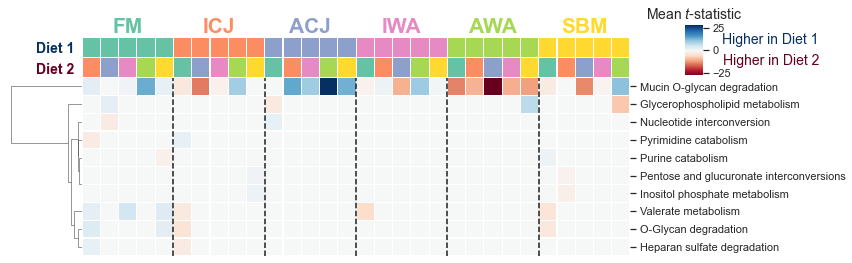

In [56]:
# Clustered heatmap of mean t-statistics (customized for data from Jeleel)
if suffix == 'jeleel':
    sns.set(font_scale=1)

    diets = diet_order[suffix]

    p = dict(zip(diets, diet_palette))
    col_colors = [[p[x[0]] for x in df.columns], [p[x[1]] for x in df.columns]]

    cbar_pos = (0.8, 0.72, 0.02, 0.175)
    figsize=(12, len(df) / 2.5)
    dendrogram_ratio=0.12
    colors_ratio=0.08

    g = sns.clustermap(df, yticklabels=1, cmap='RdBu', figsize=figsize, center=0, robust=False, dendrogram_ratio=dendrogram_ratio, col_colors=col_colors, cbar_pos=cbar_pos, colors_ratio=colors_ratio, method='ward', col_cluster=False, linewidth=0.1, xticklabels=False)
    for i in range(len(diets) - 1):
        g.ax_heatmap.axvline(x=5 * (i + 1), ymin=0, ymax=len(df), c='k', ls='--')

    fontsize = 14
    g.ax_heatmap.set_xlabel('')
#     g.ax_heatmap.set_ylabel('Enriched metabolic subsystems', fontsize=fontsize)
    for i, diet in enumerate(diets):
        g.ax_heatmap.text(2.5 + i * 5, -2.5, diet, ha='center', fontsize=fontsize * 1.5, color=p[diet], weight='bold')
    g.ax_heatmap.text(-2.5, -1.4, 'Diet 1', ha='left', weight='bold', color='#053061', fontsize=fontsize)
    g.ax_heatmap.text(-2.5, -0.2, 'Diet 2', ha='left', weight='bold', color='#67001f', fontsize=fontsize)
    g.ax_cbar.text(250, 12, 'Higher in Diet 1', ha='center', va='center', color='#053061', fontsize=fontsize)
    g.ax_cbar.text(250, -12, 'Higher in Diet 2', ha='center', va='center', color='#67001f', fontsize=fontsize)
    g.ax_cbar.set_title('Mean $t$-statistic', fontsize=fontsize)

    g.savefig(join(plot_dir, 'subsys_clustermap_' + suffix + '.pdf'), bbox_inches='tight')